# The OLG model with population growth

# Model Description

We choose an OLG model, having the following attributes:
* Time is discrete and infinite
* Agents in the economy live for only 2 periods
* The population grows at a constant rate n
* Agents supply 1 unit of labor when young, splitting their wage between consumption and savings
* Agents do not work when old, and simply live off their gross savings
* Production is according to a well-behaved CD production function

Our model consists of the following equations:

$$L_{t+1} = L_{t}(1+n)$$
$$Y_t = AK_t^aL_t^{1-a}$$
$$U_t = u(c_{1t}) + \beta u(c_{2t+1})$$
$$u(c_t) = log(c_t)$$
$$K_{t+1} = S_t = s_tL_t$$
$$k_t = \frac{K_t}{L_t}$$

Budget constraints:
$$c_{1t} + s_t = w_t$$
$$c_{2t+1} = (1+r_{t+1})s_t$$

lifetime BC:
$$c_{1t} + \frac{c_{2t+1}}{1+r_{t+1} } = w_t $$


Parameter expression:
$$\beta = \frac{1}{1 + \rho}$$


Imports and set magics:

In [ ]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as model

# Model analysis

In the following section we will solve the model analytically primarely using sympy, it should be noted that the solution is for ckapital per capita denotdt be lower case k.
We do this by differentiation of the utility after substitution in the budget contraints and then isolating k with the knowlege of the relationship between s and k given by the model equations. 

In [ ]:
##solving model for k*
##we define the parameters and functions:
from IPython.display import display, Math

# Define parameters
beta = sm.symbols('beta')
alpha = sm.symbols('alpha')
n = sm.symbols('n')
rt = sm.symbols('r_t')
wt = sm.symbols('w_t')
Kt = sm.symbols('K_t')
Lt = sm.symbols('L_t')

rho = sm.symbols('rho')
kt = sm.symbols('k_t')
kt_1 = sm.symbols('k_{t+1}')
k = sm.symbols('k*')
# Define production function
f = Kt**alpha * Lt**(1-alpha)

# Solve for wage and MPK
mpl = sm.diff(f, Lt)

#substitute in kt
mpl_sub = mpl.subs(Kt**(alpha)*Lt**(1-alpha)*Lt**(-1), kt**alpha)
w_eq = sm.Eq(wt, mpl_sub)

# Print the resulting equation
print("wage equation for w_t:")
display(Math(sm.latex(w_eq)))


# Define household utility
c1t, c2t_1 = sm.symbols('c_{1t} c_{2t+1}')
wt, rt_1 = sm.symbols('w_t r_{t+1}')
st = sm.symbols('s_t')
c1t = wt - st
c2t_1 = (1+rt_1)*st
U = sm.log(c1t) + beta*sm.log(c2t_1)

# Find the derivative of U with respect to st
dU = sm.diff(U, st)

print("differentiated utility:")
display(Math(sm.latex(dU)))

#solve for s_t
s_eq = sm.Eq(0, dU)
st_path = sm.solve(s_eq, st)[0]

print('s_t:')
display(Math(sm.latex(st_path)))


# Define the equation
st_path_sub=st_path.subs(wt, mpl_sub)

print('s_t with w_t inserted:')
display(Math(sm.latex(st_path_sub)))

#we know that k_(t+1)=s_t/(1+n)
kt_1 = st_path_sub/(1+n)

#As we are looking for steady state we can set k_(t+1)=k_t
kt_1_sub = kt_1.subs(kt, k)
ss_solve = sm.Eq(k, kt_1_sub)



k_ss = sm.solve(ss_solve, k)
print('steady state for capital per capita')
display(Math(sm.latex(k_ss)))


f_kss = sm.lambdify((alpha, n, beta), k_ss)
print('steady state for capital per capita, numerically')
print(f_kss(0.3, 0.05, 0.97))

Note that the steady state level of capital per capita is the same as usually found in the textbooks, however python has chosen to rewrite this expression weirdly

From this we can see that the steady state for k*, which is the value of capital where k in period t is equal to k in period t+1, is equal to around 0.2.

# Model simulation

We have used the optimize.root_scalar and bisect method, so to find the root of the euler error, as this should be zero. We have done this by finding the interval where the error changes sign, and used the corresponding s-values to create a bound that the optimal s should be in. the bisection method then bisects this interval to find a root

Now we solve the model using an optimiazation routine and then simulate it. Then we plot the development of capital as time goes towards the teadty state level found in the section above. We oe so for different values of the parameters we have se, to examinee the impact on the long run capital levels in the economy.

In [420]:
#Initializing the model
from modelproject import OLGModelClass

model = OLGModelClass()

par = model.par 
sim = model.sim 

from modelproject import simulate_before_s, simulate_after_s, find_s_bracket, calc_euler_error

s_guess = 0.4

#Simulating some periods of the model manually
simulate_before_s(par,sim,t=0)
print(f'{sim.C2[0] = : .4f}')

simulate_after_s(par,sim,s=s_guess,t=0)
print(f'{sim.C1[0] = : .4f}')

simulate_before_s(par,sim,t=1)
print(f'{sim.C2[1] = : .4f}')

simulate_after_s(par,sim,s=s_guess,t=1)
print(f'{sim.C1[1] = : .4f}')

#Calculating the Euler-error
LHS_Euler = sim.C1[0]**(-1)
RHS_Euler = (1+sim.r[1])*par.beta * sim.C2[1]**(-1)
print(f'euler-error = {LHS_Euler-RHS_Euler:.8f}')

#Check if euler-error goes to 0:
model.simulate()
LHS_Euler = sim.C1[18]**(-1)
RHS_Euler = (1+sim.r[19])*par.beta * sim.C2[19]**(-1)
print(LHS_Euler-RHS_Euler)

k_old=sim.k.copy()

sim.C2[0] =  0.2504
sim.C1[0] =  0.2105
sim.C2[1] =  0.3126
sim.C1[1] =  0.2411
euler-error = -2.16153417
simulation done in 0.03 secs
6.662004281565714e-12


simulation done in 0.03 secs


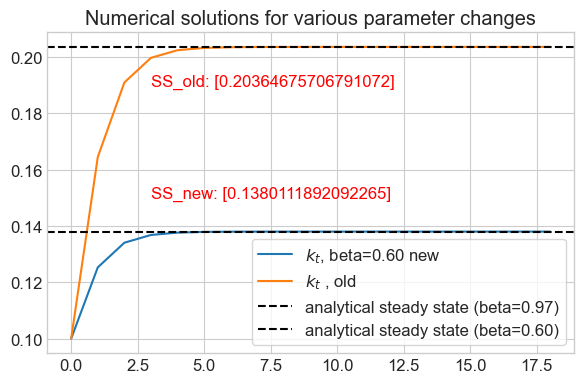

In [421]:
#New parameter change of beta:
par.beta = 0.60
# New steady state
k_ss_new1 = f_kss(0.3, 0.05, 0.60)

#Simulate model and log k
model.simulate()
k_new1 = model.sim.k

#Visualisation
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(k_new1,label=r'$k_{t}$, beta=0.60 new')
ax.plot(k_old,label=r'$k_{t}$ , old')
ax.axhline(k_ss,ls='--',color='black',label='analytical steady state (beta=0.97)')
ax.axhline(k_ss_new1,ls='--',color='black',label='analytical steady state (beta=0.60)')
ax.legend(frameon=True,fontsize=12)
ax.set_title("Numerical solutions for various parameter changes")
ax.annotate(f'SS_old: {k_ss}', xy=(3, 0.19), xycoords='data', color='red')
ax.annotate(f'SS_new: {k_ss_new1}', xy=(3, 0.15), xycoords='data', color='red')
fig.tight_layout()

From the plot it is clear that the long run steady state levels fall as beta falls, where beta is an expression that is negatively affected by rho, which is the discounting rate cf. model equations. This is due to the fact that people care less about the future consumption and therefore consumes more today and save less for consumption tomorow, leading to less capital overall because it dosen't accumulate due to interet rates.  

Changes to alpha (the weight of captail in the production function)

simulation done in 0.03 secs


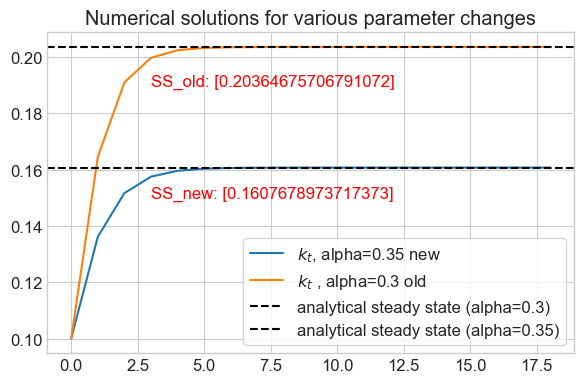

In [422]:
#New parameter change
par.alpha = 0.35
#Reset beta-value
par.beta = 0.97

#New steady state
k_ss_new1 = f_kss(0.35, 0.05, 0.97)
#Simulate model and log k
model.simulate()
k_new1 = model.sim.k

#Visualisation
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(k_new1,label=r'$k_{t}$, alpha=0.35 new')
ax.plot(k_old,label=r'$k_{t}$ , alpha=0.3 old')
ax.axhline(k_ss,ls='--',color='black',label='analytical steady state (alpha=0.3)')
ax.axhline(k_ss_new1,ls='--',color='black',label='analytical steady state (alpha=0.35)')
ax.legend(frameon=True,fontsize=12)
ax.set_title("Numerical solutions for various parameter changes")
ax.annotate(f'SS_old: {k_ss}', xy=(3, 0.19), xycoords='data', color='red')
ax.annotate(f'SS_new: {k_ss_new1}', xy=(3, 0.15), xycoords='data', color='red')
fig.tight_layout()

From the plot we can see that the long run capital levels and therebby the seadyy state eavels fall as alpha becomes larger, this is due to the fact that the productivity of capital rises such that less caitall is needed to maintain the same production levels. 

Changes to n (the population growth)

simulation done in 0.03 secs


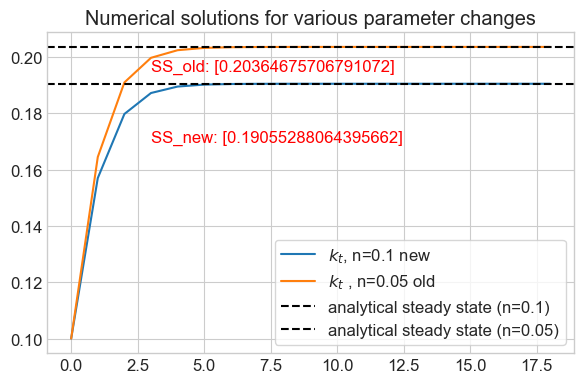

In [423]:
#New parameters
par.n = 0.10
#Reset alpha-value
par.alpha = 0.3
#New steady state
k_ss_new1 = f_kss(0.30, 0.10, 0.97)
#Simulate the model and log k
model.simulate()
k_new1 = model.sim.k

#Visualization
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(k_new1,label=r'$k_{t}$, n=0.1 new')
ax.plot(k_old,label=r'$k_{t}$ , n=0.05 old')
ax.axhline(k_ss,ls='--',color='black',label='analytical steady state (n=0.1)')
ax.axhline(k_ss_new1,ls='--',color='black',label='analytical steady state (n=0.05)')
ax.legend(frameon=True,fontsize=12)
ax.set_title("Numerical solutions for various parameter changes")
ax.annotate(f'SS_old: {k_ss}', xy=(3, 0.195), xycoords='data', color='red')
ax.annotate(f'SS_new: {k_ss_new1}', xy=(3, 0.17), xycoords='data', color='red')
fig.tight_layout()

As shown in the plot above, the steady state of capital per capita decreases when n increases. This makes intuitive sense and can also be seen in the analytical solution, as an increase in population growth means there are more people to distribute the capital on, the capital per capita will be lower.

We extend our model such that we introduce a goverment that raises contributions from the current young, invests them, and then pays benefits to the contributors, when they are old. This is also known as a fully funded OLG model. 

# Governeemnt implementation, Fully Funded system

simulation done in 0.04 secs
savings_rate_old[18]: 0.49238578680291384
savings_rate_new[18]: 0.36548223350116776


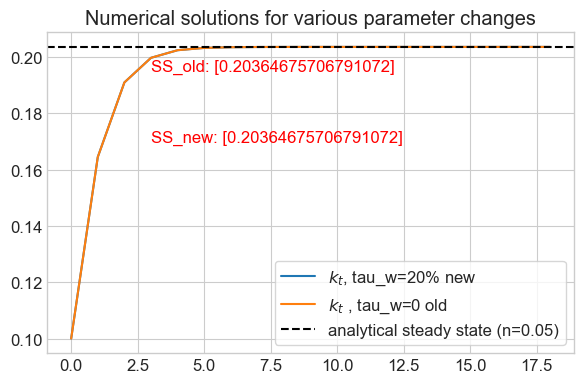

In [424]:
#initialize a wage tax
par.tau_w = 0.2
par.n = 0.05
par.alpha = 0.3

#There is no change to the analytical steady state capital per capita, as we assume that the funds of the social system has the same interest rate as the private sector
#Thus, there is no need to recalculate the analytical SS. The 20% tax is thus just a lower limit on savings, having no effect, as s_opt = 49 % > 20 %.
#Note that the savings_rate given below is of disposable income, and the new savings rate is therefore 36%, rather than 49-20 = 29 %.

#Model simulation and log k
model.simulate()
k_new1 = model.sim.k

#Visualisation
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(k_new1,label=r'$k_{t}$, tau_w=20% new')
ax.plot(k_old,label=r'$k_{t}$ , tau_w=0 old')
ax.axhline(k_ss,ls='--',color='black',label='analytical steady state)')
ax.legend(frameon=True,fontsize=12)
ax.set_title("Numerical solutions for various parameter changes")
ax.annotate(f'SS_old: {k_ss}', xy=(3, 0.195), xycoords='data', color='red')
ax.annotate(f'SS_new: {k_ss}', xy=(3, 0.17), xycoords='data', color='red')
print(f'savings_rate_old[18]: {s_old[18]}')
print(f'savings_rate_new[18]: {sim.savings[18]}')
fig.tight_layout()


When introducing a government and a fully funded system, we find that the steady state capital level doesnt change. However the savings rate goes down corresponding to what the tax is, so the same amount is invested as before. he households simply adjust their savings to take the "forced savings" (the tax) into account when choosing how much of their wage to save.  Note again that the savings rate is the savings rate according to the disposable income. 

# Conclusion

We find that it is possible to use the numerical method of solving the model and get the same steady state as we do analytically (see figure 1). When increasing the population growth, the productivity of capital or decreasing the discount factor, the steady state level of capital per capita falls as expected both analytically and intuitively.

When introducing a government and a wage tax, we find that while the steady state capital per capita remains the same, the savings rate decreases as they take the tax as a pension they dont have to save themselves